In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
gridmet = catalog.get_collection("gridmet")
asset = planetary_computer.sign(gridmet.assets["zarr-abfs"])
asset

<Asset href=abfs://gridmet/gridmet.zarr>

In [2]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 3
  * lat                                        (lat) float64 49.4 ... 25.07
  * lon                                        (lon) float64 -124.8 ... -67.06
  * time                                       (time) datetime64[ns] 1979-01-...
Data variables:
    air_temperature                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

## SELECTING PRECIPATION DATA FOR 2020
Our goal for this example is to obtain the aridity index for 2020 as the average of the the aridity indices for every month in the year 2020. 
First we will select the precipitation data for 2020 and clip it to California.
Notice that 2020 is a leap year, that is why in the **time** dimension we see 366 units. We can further check this is the data we want by looking at the coordinates section of the info. We can see the **time** coordinate goes from 2020-01-01 to 2020-12-31.

In [3]:
prec = ds["precipitation_amount"].sel(time=slice('2020-01-01','2020-12-31'))
prec

<xarray.DataArray 'precipitation_amount' (time: 366, lat: 585, lon: 1386)>
dask.array<getitem, shape=(366, 585, 1386), dtype=float32, chunksize=(30, 585, 1386), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Accumulated Precipitation
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          pr
    standard_name:      pr
    units:              mm

## MASKING PRECIPITATION DATA TO CALIFORNIA
We will import a shapefile of CA to do this. To correctly mask the precipitation data we need to make sure the shapefile and the xarray.DataArray have the same crs. Looking at the attributes of `prec` we can see the crs is the attribute *coordinate_system*, so we can use this to transform the shapefile. For the shapefile we can simply do `shapefile_name.crs`.

In [4]:
# extract crs from xarray.DataArray
crs= ds.attrs['coordinate_system']
crs

'EPSG:4326'

epsg:3857


<AxesSubplot:>

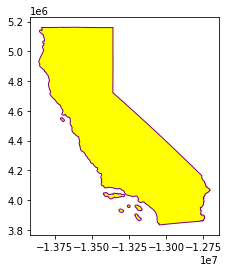

In [5]:
import geopandas as gpd

# import shapefile
ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)
print(ca_shape.crs) # notice it is a different EPSG
ca_shape.plot(edgecolor='purple', color='yellow')

<AxesSubplot:>

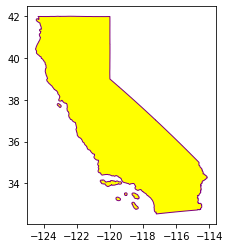

In [6]:
# match CRS
ca_match = ca_shape.to_crs(ds.attrs['coordinate_system'])
ca_match.plot(edgecolor='purple', color='yellow')

In [7]:
# clip to CA
prec = prec.rio.write_crs(crs)
ca_prec = prec.rio.clip(ca_match.geometry, ca_match.crs)
ca_prec

<xarray.DataArray 'precipitation_amount' (time: 366, lat: 227, lon: 249)>
dask.array<getitem, shape=(366, 227, 249), dtype=float32, chunksize=(30, 227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    crs      int64 0
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Accumulated Precipitation
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          pr
    standard_name:      pr
    units:              mm

## PREPARING EVAPOTRANSPIRATION DATA
We do the same data selection and masking for the evapotranspiration data. 

In [8]:
evap = ds["potential_evapotranspiration"].sel(time=slice('2020-01-01','2020-12-31'))
evap = evap.rio.write_crs(crs)
ca_evap = evap.rio.clip(ca_match.geometry, ca_match.crs)
ca_evap

<xarray.DataArray 'potential_evapotranspiration' (time: 366, lat: 227, lon: 249)>
dask.array<getitem, shape=(366, 227, 249), dtype=float32, chunksize=(30, 227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    crs      int64 0
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily reference evapotranspiration (short grass)
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          pet
    standard_name:      pet
    units:              mm

## COMPUTE ARIDITY INDEX FOR JANUARY
The `ca_prec` and `ca_evap` datasets both 366 layers along the time dimension (because 2020 is a leap year). We want to compute the aridity index for each month of the year. As a first example, let's see what is the AI for January 2020.

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


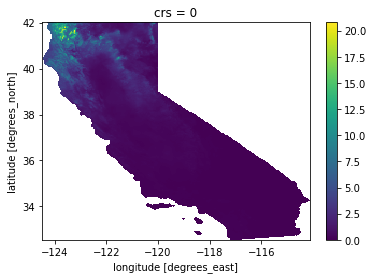

In [9]:
m_prec = ca_prec.sel(time=slice('2020-01-01','2020-01-31'))
m_evap = ca_evap.sel(time=slice('2020-01-01','2020-01-31'))

total_prec = m_prec.sum(dim='time')
total_evap = m_evap.sum(dim='time')

ai_m = total_prec/total_evap
ai_m.plot()

From the map it seems like the aridity index for january has some extreme values around 20. Most of the map seems pretty dark, so there most of the values are closer to 0. Let's try some descriptive statistics to verify this. To do so we will extract the array part of the xarra.DataArray as a numpy.dataarray. 

max:  20.785297
min:  0.0


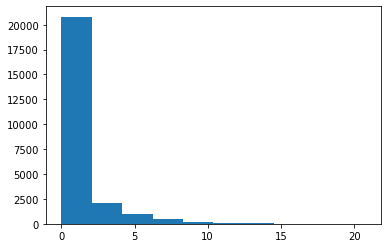

In [10]:
import numpy as np
import matplotlib.pyplot as plt

array = ai_m.to_numpy()
array = array[~np.isnan(array)]

print('max: ', np.max(array))
print('min: ', np.min(array))

freq, edges = np.histogram(array)
plt.stairs(freq, edges, fill=True)

## COMPUTE ARIDITY INDEX FOR EACH MONTH
Next we want to compute the aridity index for each month and stack them all together in the same xarray.DataArray. To do this we will use the following functions, they select the dates of each month carefully and calcualte the ariditi index accordingly.

In [11]:
import calendar

# return: date of the last date of a given month in a given year
# month: integer 1,...,12
# year: integer 1979, ..., 2020 
def mth_end(month,year):
    if month in (1,3,5,7,8,10,12):
        return str(year)+'-'+str(month)+'-31'
    if month in (4,6,9,11):
        return str(year)+'-'+str(month)+'-30'
    if calendar.isleap(year):
        return str(year)+'-02-29'
    return str(year)+'-02-28'

# return: aridity index for a given month in a given year
# month: integer 1,...,12
# year: integer 1979, ..., 2020 
# evap = subset of ds["potential_evapotranspiration"] containng the month of interest
# prec = subset of ds["precipitation_amount"] containng the month of interest
def mth_arid_index(month,year,prec,evap):
    m_prec = prec.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    m_evap = evap.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    
    total_prec = m_prec.sum(dim='time')
    total_evap = m_evap.sum(dim='time')
    
    return total_prec/total_evap

To create the stack of monthly aridity indices we will start with the aridity index on January 2020 and then add to it the rest of the months using `xarray.concat()`.
**NOTE** It would be nicer to initialize an empty xarray.DataArray and then add the 12 months to it.

In [12]:
stack = mth_arid_index(1,2020,ca_prec,ca_evap)
# notice we already have the first month and we need to include the 12th month
for i in range(2,13):   
    month_ai = mth_arid_index(i,2020,ca_prec,ca_evap)
    # [first position, last position]
    # **** REMOVE CONCAT AND TRY TO DO THIS MORE EFFICIENTLY ****
    stack = xr.concat([stack,month_ai], dim='time', combine_attrs='drop')
stack

<xarray.DataArray (time: 12, lat: 227, lon: 249)>
dask.array<concatenate, shape=(12, 227, 249), dtype=float32, chunksize=(1, 227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0
Dimensions without coordinates: time

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


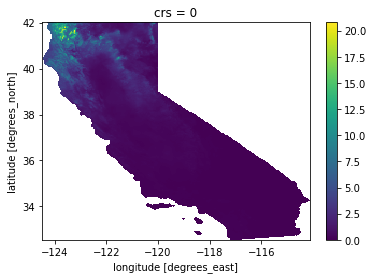

In [13]:
stack.sel(time=0).plot()

## MONTHLY ARIDITY INDEX ANIMATION

In [14]:
# https://planetarycomputer.microsoft.com/dataset/gridmet#Example-Notebook

# import matplotlib.pyplot as plt
# import matplotlib.animation
# import cartopy.crs as ccrs

# map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

# fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=map_proj))
# ax.set_axis_off()
# quadmesh = stack[0].plot(
#     ax=ax, add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree()
# )


# def animate(i):
#     a = stack[i].data.ravel()
#     a2 = np.ma.array(a, mask=np.isnan(a))
#     quadmesh.set_array(a2)
#     return [quadmesh]

# anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(stack), interval=120)
# anim.save("anim.mp4", fps=15, extra_args=["-vcodec", "libx264"])
#anim

In [15]:
# from IPython.display import Video

# Video("/home/jovyan/aridity_layer/anim.mp4")

## COMPUTE ARIDITY INDEX 2020
Here we calculate the aridity index for 2020 as the average of each monthly aridity index. The monthly aridity index is calculated as the (total precipitation during the month (mm))/(total evapotranspiration during the month (mm)). We also update the attributes.

In [96]:
ai2020 = stack.mean(dim='time')
ai2020.attrs['long_name'] = 'California 2020 Aridity Index as Average of Monthly Aridity Indices'
ai2020.attrs['year']=2020
#ai2020

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


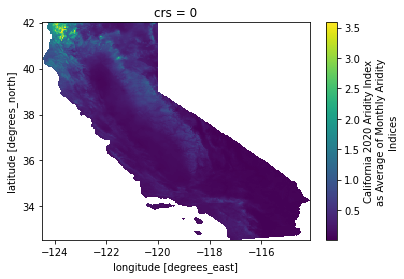

In [17]:
ai2020.plot()

As before, we can see most of the values are less than one. 

max:  3.5832918
min:  0.010034756


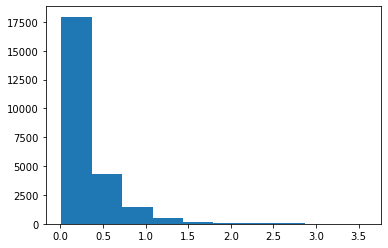

In [18]:
array = ai2020.to_numpy()
array = array[~np.isnan(array)]

print('max: ', np.max(array))
print('min: ', np.min(array))

freq, edges = np.histogram(array)
plt.stairs(freq, edges, fill=True)

In [49]:
ai2020

Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0

## STORING CRS ON XARRAY

For this example we will figure out how to encode the CRS into our xarray. We can see in the info above that the crs is already encoded as a coordinate of the xarray.DataArray. This coordiante has a single value 0, and actually has all the info as attributes. What if we did not have this coord and want to set up the CRS manually? For the sake of experience, let's drop that crs coordinate. 

In [97]:
print('current coords: ', ai2020.coords, '\n')
ai2020 = ai2020.reset_coords('crs',drop=True)
print('current coords: ', ai2020.coords, '\n')

current coords:  Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0 

current coords:  Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 



If we look at the xarray API reference we will see there is nothing about specifying a crs. We actually need to use rioxarray for this. We will check what two of these methods do:

`set_crs(input_crs, inplace=True)`

*Set the CRS value for the Dataset/DataArray without modifying the dataset/data array*

`write_crs(input_crs=None, grid_mapping_name=None, inplace=False)`

*Write the CRS to the dataset in a CF compliant manner.*

In [98]:
# No specified crs in rio.crs, coords or attributes

print('current crs: ', ai2020.rio.crs, '\n')
print('current coords: ', ai2020.coords, '\n')
print('current attrs: ',[*ai2020.attrs])

current crs:  None 

current coords:  Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'year']


In [99]:
# Specify crs within rioxarray
ai2020.rio.set_crs(crs)
print('current crs: ', ai2020.rio.crs, '\n')
print('current coords: ', ai2020.coords, '\n')
print('current attrs: ',[*ai2020.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'year']


In [102]:
# Write crs as coord
ai2020.rio.write_crs(crs, inplace=True)
print('current crs: ', ai2020.rio.crs, '\n')
print('current coords: ', ai2020.coords, '\n')
#print(' -- RENAME FROM spatial_ref TO crs--') ** NOT WORKING **
#ai2020.rename({'spatial_ref':'crs'})
#print('current coords: ', ai2020.coords, '\n')
print('current attrs: ',[*ai2020.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
  * lat          (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon          (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
    spatial_ref  int64 0 

current attrs:  ['long_name', 'year']


In [103]:
# Include crs as metadata by making it an attribute
ai2020.attrs['coordinate_system']=ds.attrs['coordinate_system']
print('current crs: ', ai2020.rio.crs, '\n')
print('current coords: ', ai2020.coords, '\n')
print('current attrs: ',[*ai2020.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
  * lat          (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon          (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
    spatial_ref  int64 0 

current attrs:  ['long_name', 'year', 'coordinate_system']


In [104]:
ai2020

<xarray.DataArray (lat: 227, lon: 249)>
dask.array<mean_agg-aggregate, shape=(227, 249), dtype=float32, chunksize=(227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon          (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
    spatial_ref  int64 0
Attributes:
    long_name:          California 2020 Aridity Index as Average of Monthly A...
    year:               2020
    coordinate_system:  EPSG:4326

## ARIDITY REGIONS
There is something tricky here, so read carefuly!!

We want to reclassify pixels into discrete categories to obtain a map of Moisture Domains. The thresholds are from the the paper *An assessment of the representation of ecosystems in global protected areas using new maps of World Climate Regions and World Ecosystems*. These are:

| Moisture Domain | Aridity Index (A) | 
| ----------------|---------------|
| Desert (Hyperarid) | A <0.05
| Dry (Arid) | 0.05 <= A < 0.65 |
| Moist (Humid) | 0.65 < A |


To reclassify the pixels we will first extract the underlying np.ndarray from the xarray.DataArray. We will try to reclassify the array in two different ways and then realize one does not work and see why. 

### FIRST TRIAL: does not work

[3.]


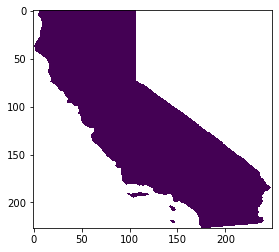

In [19]:
# extract numpy.ndarray
ai_rgns = ai2020.to_numpy()
# establish thresholds
k = [0.05,0.65]

# reclassify
ai_rgns[np.where( ai_rgns< k[0])] = 1
ai_rgns[np.where( (k[0]<=ai_rgns) & (ai_rgns<k[1]))] = 2
ai_rgns[np.where(k[1]<=ai_rgns)] = 3

plt.imshow(ai_rgns)
ai_rgns = ai_rgns[~np.isnan(ai_rgns)]  # remove nan
print(np.unique(ai_rgns))


What is going on? The issue here is we have to remember that each line of code is fed to the next one. When we do `ai_rgns[np.where( ai_rgns< k[0])] = 1` all those pixels are now assigned a value of 1. When those pixels get to the third line we have that `0.65 = k[1] < 1` so the pixels that were classified as 1 get assigned a value of 3 in the end. The same happens to the line `ai_rgns[np.where( (k[0]<=ai_rgns) & (ai_rgns<k[1]))] = 2`. One way of fixing it is just having `ai_rgns[np.where(k[1]<=ai_rgns)] = 3` first. 

### SECOND TRIAL: works

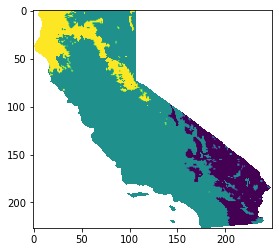

In [20]:
# reset numpy.ndarray
ai_rgns = ai2020.to_numpy()

# reclassify
ai_rgns[np.where(k[1]<=ai_rgns)] = 3
ai_rgns[np.where( ai_rgns< k[0])] = 1
ai_rgns[np.where( (k[0]<=ai_rgns) & (ai_rgns<k[1]))] = 2

plt.imshow(ai_rgns)
## We can still run these next two lines to verify that we have all three categories.
## However, we'd be destroying the array's structure removing the nans, and we need to keep the array
## for the next step.
#ai_rgns = ai_rgns[~np.isnan(ai_rgns)]  # remove nan
#print(np.unique(ai_rgns))

## CHANGING DATA TYPE AND DEALING WITH NODATA VALUES
First we will make this np.ndarray into an xarray.DataArray. Notice the data type of the resulting xarray.DataAarray is float32. This is using way too much memory for something that only holds four integer values. So we will change the data type to uint8. Since `nan` is not a valid value for unit8 these will get replaced by 0s. That is ok, we will just manually specify 0 is the new nodata type of the raster. 

[Read more about Nodata Management here](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html)

original dtype: float32
updated dtype: uint8


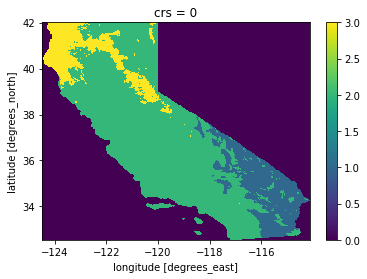

In [21]:
# create xarray.DataArray with np.ndarray
ai_regions = xr.DataArray(
    data= ai_rgns,
    dims= ai2020.dims,
    coords= ai2020.coords
)
# check data type and update it uint8
print('original dtype:',ai_regions.dtype)
ai_regions = ai_regions.astype('uint8')
print('updated dtype:',ai_regions.dtype)
ai_regions.plot()

Now we can check the nodata: notice there is no value encoded

In [22]:
# check nodata values and update it to 0
print('nodata:',ai_regions.rio.nodata)
print('encoded_nodata:', ai_regions.rio.encoded_nodata)

nodata: None
encoded_nodata: None


In [23]:
ai_regions.rio.write_nodata(0, inplace=True)
print('nodata:',ai_regions.rio.nodata)
print('encoded_nodata:', ai_regions.rio.encoded_nodata)

nodata: 0
encoded_nodata: None


**What is the difference between nodata and encoded_nodata?**
I do not yet, but will find out some day...
For the time being, we will store `nodata=0` as an attribute for the DataArray so this information does not get lost. 

## UPDATING ATTRIBUTES

To finish we will add some descriptive attributes. We want to encode what each region code (1,2,3) means. On my first try I did this as a dictionary:

In [24]:
# d ={ 1: 'Desert (Hyperarid): aridity index less than '+str(k[0]),
#      2: 'Dry (Arid): aridity index in ['+str(k[0])+','+str(k[1])+')',
#      3: 'Moist (Humid): aridity index geq than '+str(k[1])}`

# ai_regions.attrs['regions_codes']=d

This will work fine, except that we cannot export a dictionary as an attribute in netCDF file. So instead we will make an attribute of each region code.

In [25]:
# update attributes
ai_regions.attrs['long_name'] = 'California Moisture Domains Based on 2020 Aridity Index'
ai_regions.attrs['year']=ai2020.attrs['year']
ai_regions.attrs['coordinate_system']=ds.attrs['coordinate_system']

ai_regions.attrs['nodata_value']=0
ai_regions.attrs['code_1']= 'Desert (Hyperarid): aridity index less than '+str(k[0])
ai_regions.attrs['code_2']= 'Dry (Arid): aridity index in ['+str(k[0])+','+str(k[1])+')'
ai_regions.attrs['code_3']= 'Moist (Humid): aridity index geq than '+str(k[1])

#ai_regions.plot()

In [106]:
# Double check we have all the crs info
ai_regions.rio.set_crs(crs)
print('current crs: ', ai_regions.rio.crs, '\n')
print('current coords: ', ai_regions.coords, '\n')
print('current attrs: ',[*ai_regions.attrs])

current crs:  EPSG:4326 

current coords:  Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0 

current attrs:  ['_FillValue', 'long_name', 'coordinate_system', 'year', 'nodata_value', 'code_1', 'code_2', 'code_3']


In [26]:
ai_regions

<xarray.DataArray (lat: 227, lon: 249)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0
Attributes:
    _FillValue:         0
    long_name:          California Moisture Domains Based on 2020 Aridity Index
    coordinate_system:  EPSG:4326
    year:               2020
    nodata_value:       0
    code_1:             Desert (Hyperarid): aridity index less than 0.05
    code_2:             Dry (Arid): aridity index in [0.05,0.65)
    code_3:             Moist (Humid): aridity index geq than 0.65

## Group Aridity Index and Regions Maps into `xarray.Dataset`

In [27]:
info = { 'long_name': 'CA Aridity Index and Moisture Domains (2020)',
         'year' : 2020,
         'about_data' : 'generated using daily gridMET dataset, accessed through Microsoft Planetary Computer',
         'author' : 'C. Galaz García'
       }
ca_aridity2020 = xr.Dataset(attrs = info)
ca_aridity2020

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    long_name:   CA Aridity Index and Moisture Domains (2020)
    year:        2020
    about_data:  generated using daily gridMET dataset, accessed through Micr...
    author:      C. Galaz García

In [28]:
ca_aridity2020 = ca_aridity2020.assign(aridity_index = ai2020,
                                       aridity_regions = ai_regions)
ca_aridity2020

<xarray.Dataset>
Dimensions:          (lat: 227, lon: 249)
Coordinates:
  * lat              (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon              (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
    crs              int64 0
Data variables:
    aridity_index    (lat, lon) float32 dask.array<chunksize=(227, 249), meta=np.ndarray>
    aridity_regions  (lat, lon) uint8 0 0 0 0 0 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 0
Attributes:
    long_name:   CA Aridity Index and Moisture Domains (2020)
    year:        2020
    about_data:  generated using daily gridMET dataset, accessed through Micr...
    author:      C. Galaz García

In [29]:
print(ca_aridity2020['aridity_index'].dtype)
print(ca_aridity2020['aridity_regions'].dtype)

float32
uint8


## Saving dataset
**X______X**
Cannot save the aridity_regions as uint8 data 

In [30]:
# outfp = "/home/jovyan/aridity_layer/ca_aridity2020.nc"
# ca_aridity2020.to_netcdf(outfp, 
#                          mode="w",
#                          encoding={'aridity_index':{'dtype':ca_aridity2020['aridity_index'].dtype}, 
#                                    'aridity_regions':{'dtype':ca_aridity2020['aridity_regions'].dtype}})

outfp = "/home/jovyan/aridity_layer/ca_aridity2020.nc"
ca_aridity2020.to_netcdf(outfp, 
                         mode="w",
                         engine='netcdf4',
                         encoding={'aridity_index':{'dtype':'float32'}, 
                                   'aridity_regions':{'dtype':'uint8'}}
                        )

In [31]:
check = xr.open_dataset(outfp)
check

<xarray.Dataset>
Dimensions:          (lat: 227, lon: 249)
Coordinates:
  * lat              (lat) float64 41.98 41.94 41.9 41.86 ... 32.65 32.61 32.57
  * lon              (lon) float64 -124.5 -124.4 -124.4 ... -114.2 -114.2 -114.1
    crs              int64 ...
Data variables:
    aridity_index    (lat, lon) float32 ...
    aridity_regions  (lat, lon) float32 ...
Attributes:
    long_name:   CA Aridity Index and Moisture Domains (2020)
    year:        2020
    about_data:  generated using daily gridMET dataset, accessed through Micr...
    author:      C. Galaz García

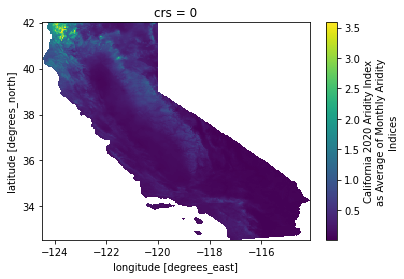

In [32]:
check['aridity_index'].plot()

In [33]:
check['aridity_index']

<xarray.DataArray 'aridity_index' (lat: 227, lon: 249)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0
Attributes:
    long_name:          California 2020 Aridity Index as Average of Monthly A...
    coordinate_system:  EPSG:4326
    year:               2020

In [34]:
diff = check['aridity_index'] - ai2020
diff = diff.to_numpy()
diff = diff[~np.isnan(diff)]  # remove nan
print(np.unique(diff))

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[0.]


In [35]:
check['aridity_regions']

<xarray.DataArray 'aridity_regions' (lat: 227, lon: 249)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0
Attributes:
    long_name:          California Moisture Domains Based on 2020 Aridity Index
    coordinate_system:  EPSG:4326
    year:               2020
    nodata_value:       0
    code_1:             Desert (Hyperarid): aridity index less than 0.05
    code_2:             Dry (Arid): aridity index in [0.05,0.65)
    code_3:             Moist (Humid): aridity index geq than 0.65

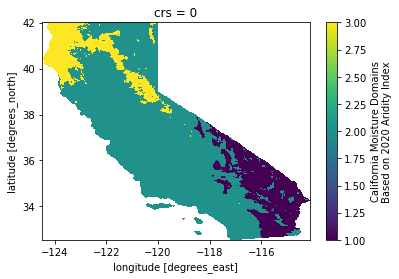

In [36]:
check['aridity_regions'].plot()

We can even check the rasters have exactly the same values.

In [37]:
diff = check['aridity_regions'] - ai_regions
diff = diff.to_numpy()
diff = diff[~np.isnan(diff)]  # remove nan
print(np.unique(diff))

[0.]


# That's it!